# Sentiment Analysis
In Natural Language Processing (NLP), sentiment analysis is a method used to detect emotions in text. It assists in categorizing text as neutral, positive, or negative and is frequently used in financial analysis, social media monitoring, business, and consumer feedback. By examining reviews, tweets, and survey results, companies may utilize them to learn about consumer preferences, enhance their products, and monitor brand reputation.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import string
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


## Load Dataset


In [2]:
data = pd.read_csv("train.csv", encoding='latin-1')
test = pd.read_csv("test.csv", encoding='latin-1')

## Concatenate Training and testing data

In [3]:
data = pd.concat([data, test])

In [4]:
data.shape

(32296, 10)

## Data Information

In [5]:
data.describe()

,Population -2020,Land Area (Km²),Density (P/Km²)
count,3.101500e+04,3.101500e+04,31015.000000
mean,4.009768e+07,6.633212e+05,356.684733
std,1.500845e+08,1.811039e+06,2008.450729
min,8.010000e+02,0.000000e+00,2.000000
25%,1.968001e+06,2.281000e+04,35.000000
50%,8.655535e+06,1.118900e+05,89.000000
75%,2.843594e+07,5.279700e+05,214.000000
max,1.439324e+09,1.637687e+07,26337.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


## Drop unnecessary column

In [7]:
data.drop(columns=['selected_text','textID','Time of Tweet','Age of User','Country','Population -2020','Land Area (Km²)','Density (P/Km²)'], axis = 1, inplace=True)

In [8]:
data.isnull().sum()

,0
text,1282
sentiment,1281


In [9]:
data.dropna(inplace=True)

In [10]:
data.isnull().sum()

,0
text,0
sentiment,0


## Preprocessing

### Change the text to lower case

In [11]:
data['cleaned_text'] = data['text'].apply(lambda x:str(x).lower())

In [12]:
data

,text,sentiment,cleaned_text
0,"I`d have responded, if I were going",neutral,"i`d have responded, if i were going"
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego!!!
2,my boss is bullying me...,negative,my boss is bullying me...
3,what interview! leave me alone,negative,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on t...",negative,"sons of ****, why couldn`t they put them on t..."
...,...,...,...
3529,"its at 3 am, im very tired but i can`t sleep ...",negative,"its at 3 am, im very tired but i can`t sleep ..."
3530,All alone in this old house again. Thanks for...,positive,all alone in this old house again. thanks for...
3531,I know what you mean. My little dog is sinkin...,negative,i know what you mean. my little dog is sinkin...
3532,_sutra what is your next youtube video gonna b...,positive,_sutra what is your next youtube video gonna b...


### Removing stopwords from data

In [13]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Removing URLs

In [14]:
def remove_urls(text):
  pattern = re.compile(r'https?://\S+|www\.\S+')
  pattern = re.compile(r'http?://\S+|www\.\S+')
  return pattern.sub(r'', text)

data['cleaned_text'] = data['cleaned_text'].apply(remove_urls)

In [15]:
data

,text,sentiment,cleaned_text
0,"I`d have responded, if I were going",neutral,"i`d responded, going"
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego!!!
2,my boss is bullying me...,negative,boss bullying me...
3,what interview! leave me alone,negative,interview! leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,"sons ****, couldn`t put releases already bought"
...,...,...,...
3529,"its at 3 am, im very tired but i can`t sleep ...",negative,"3 am, im tired can`t sleep try"
3530,All alone in this old house again. Thanks for...,positive,alone old house again. thanks net keeps alive ...
3531,I know what you mean. My little dog is sinkin...,negative,know mean. little dog sinking depression... wa...
3532,_sutra what is your next youtube video gonna b...,positive,_sutra next youtube video gonna about? love vi...


## Splitting data

In [16]:
X = data['cleaned_text']
y = data['sentiment']

## Encode the categorical values

In [18]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Applying Bag of Words (BoW)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X_train_bow = cv.fit_transform(X_train)
X_test_bow = cv.transform(X_test)

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train_bow, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [23]:
y_pred = rf.predict(X_test_bow)

In [24]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred))
score_rf = accuracy_score(y_test, y_pred)
score_rf

              precision    recall  f1-score   support

           0       0.72      0.60      0.66      1749
           1       0.66      0.73      0.69      2502
           2       0.75      0.76      0.75      1952

    accuracy                           0.70      6203
   macro avg       0.71      0.70      0.70      6203
weighted avg       0.70      0.70      0.70      6203



0.7022408512010317

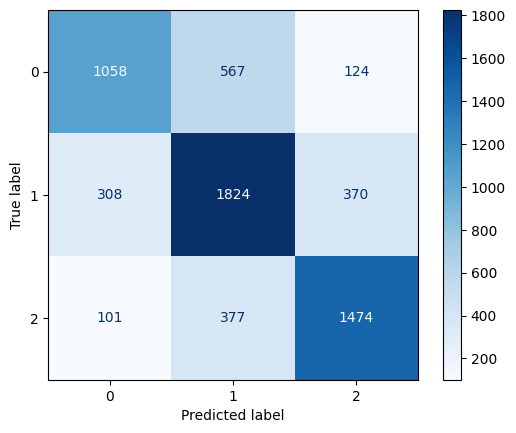

In [40]:
cm = confusion_matrix(y_test, y_pred)

dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap=plt.cm.Blues)
plt.show()

In [33]:
def wp(text):
    return text.upper()

def output_lable(n):
    if n == 0:
        return "The Text Sentement is Negative"
    elif n == 1:
        return "The Text Sentement is Neutral"
    elif n == 2:
        return "The Text Sentement is Positive"

def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wp)
    new_x_test = new_def_test["text"]
    new_xv_test = cv.transform(new_x_test)
    pred_rf = rf.predict(new_xv_test)

    return print((output_lable(pred_rf)))

In [38]:
text = "I am not happy"
manual_testing(text)

The Text Sentement is Negative


In [39]:
text = "I am good"
manual_testing(text)

The Text Sentement is Positive


In [41]:
text = "I'm healthy"
manual_testing(text)

The Text Sentement is Positive
